In [64]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

---

#### Инициализируем датафрейм и посмотрим на данные.

In [65]:
data_raw = pd.read_csv("./data/winequality-red.csv", sep=";")

In [66]:
display(data_raw.info())
display(data_raw.head())
display(data_raw.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


None

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### Все данные имеют числовой формат, обработка не требуется.

---

#### Посмотрим на распределения переменных

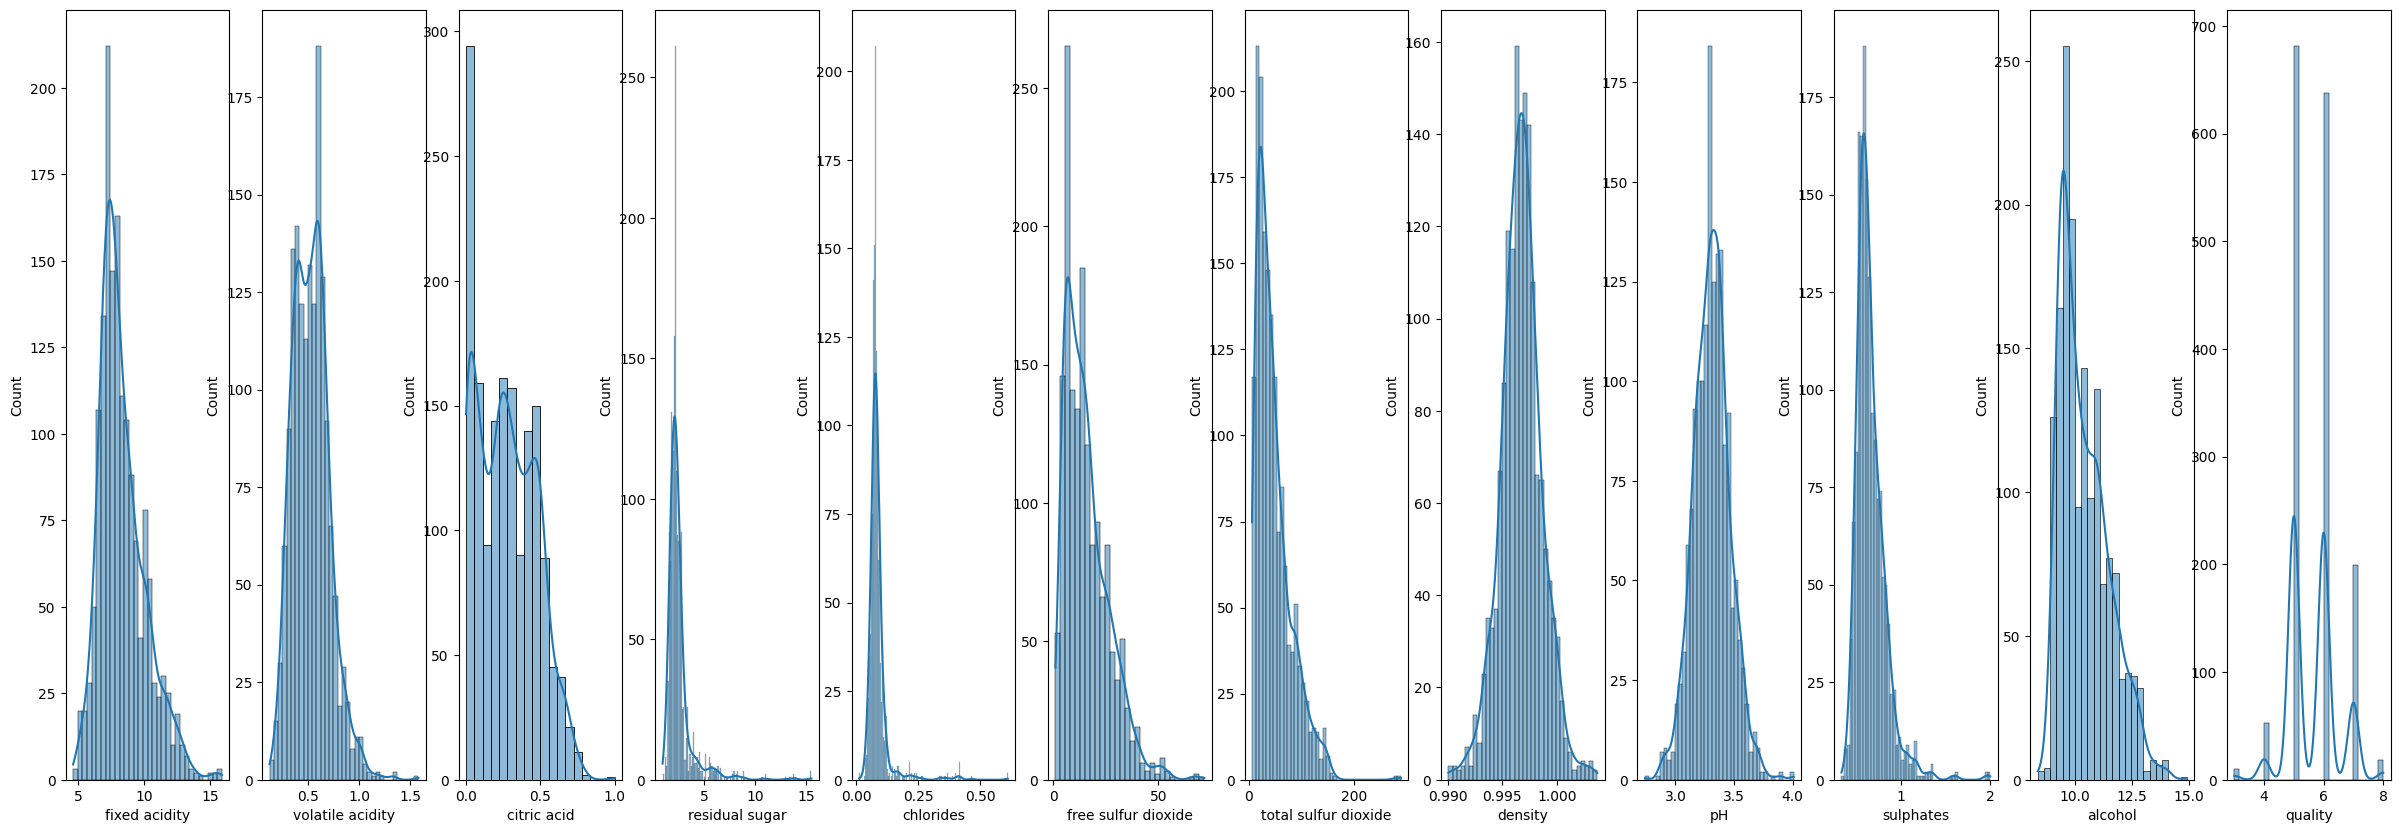

In [67]:
fig, axes = plt.subplots(1, data_raw.shape[1], figsize=(30,10))

for i,j in enumerate(data_raw.columns.to_list()):
    sns.histplot(data_raw[j], kde=True, ax=axes[i])

- fixed_acidity - распределение близко к нормальному

- volatile acidity - распределение близко к нормальному

- citric acid - распределение не нормальное

- residual sugar - распределение близко к нормальному

- chlorides - распределение близко к нормальному

- free sulfur dioxide - распределение близко к логнормальному

- total sulfur dioxide - распределение близко к логнормальному

- density - распределение близко к нормальному

- pH - распределение близко к нормальному

- sulphates - распределение близко к нормальному

- alcohol - распределение близко к нормальному

- quality - распределение не нормальное

#### Посмотрим на корреляцию признаков

<Axes: >

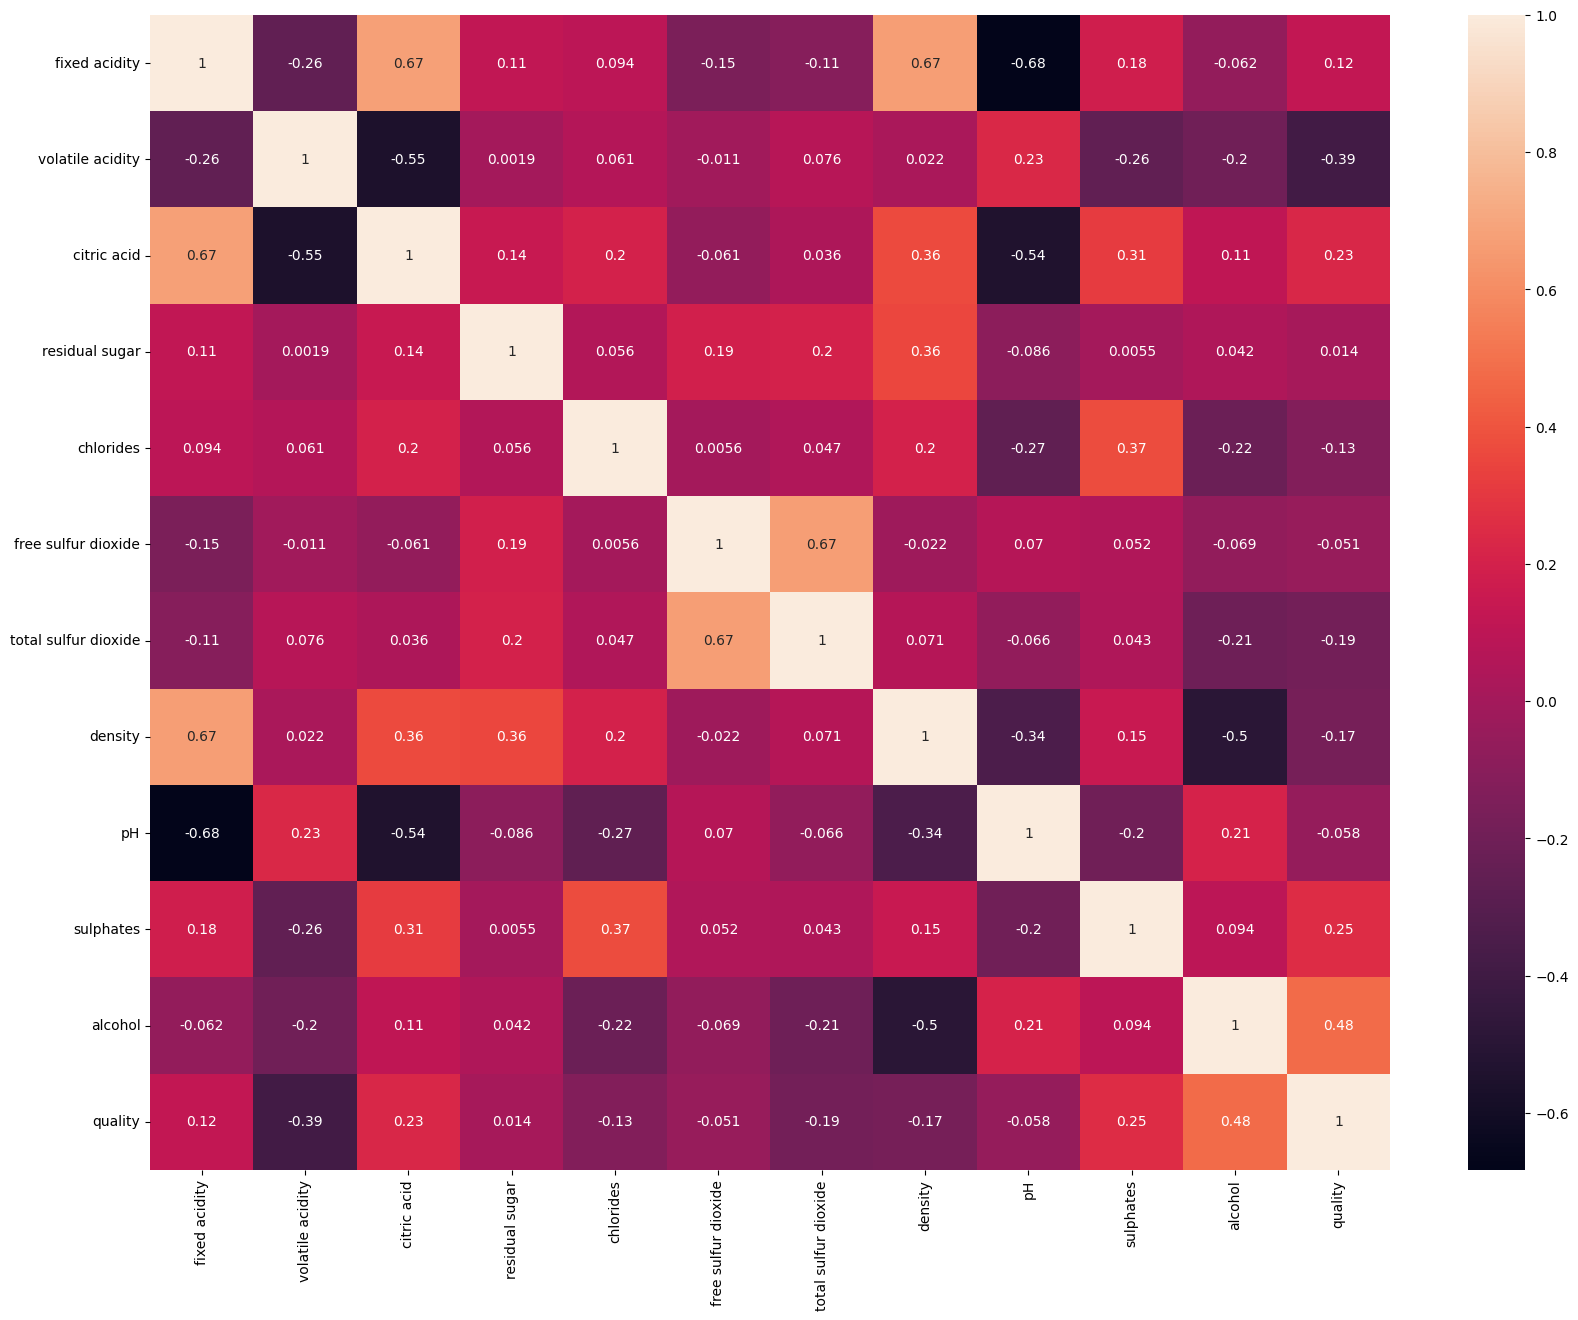

In [68]:
fig, axes = plt.subplots(1, 1, figsize=(20,15))
sns.heatmap(data_raw.corr(), annot=True, ax=axes)

Наибольшей корреляцией с таргетом обладают:

- volatile acidity - коэф-т = -0.39 справка из гугла: VA is often associated with oxidation problems in a wine due to the fact that both result from overexposure to oxygen and/or a lack of sulfur dioxide management. Acetic acid bacteria require oxygen to grow and proliferate. Обратная связь (что вытекает из определения) выше уровень - хуже качество.

- alcohol - коэф-т = 0.48 - крепость. Чем крепче тем лучше.

Из факторов с низкой корреляцией (но приемлимой в контектсе моделирования):

- fixed acidity

- citric acid 

- chlorides	

- total sulfur dioxide

- density 

- sulphates

Кандидаты на удаление из-за возможной мультиколлинеарности:

- pH

- citric acid (ковариация с fixed acidity и volatile acidity - из-за корреляции с ней и уберем)

- free sulfur dioxide (низкая корреляция с таргетом высокая с total sulfur dioxide)

- density

----

#### Проверим пропуски или нулевые значения.

In [69]:
# Сформируем рабочий датафрейм
data = data_raw.copy()

data.drop(
    ["pH", "citric acid", "free sulfur dioxide", "density"], axis=1, inplace=True
)

data.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.70,1.9,0.076,34.0,0.56,9.4,5
1,7.8,0.88,2.6,0.098,67.0,0.68,9.8,5
2,7.8,0.76,2.3,0.092,54.0,0.65,9.8,5
3,11.2,0.28,1.9,0.075,60.0,0.58,9.8,6
4,7.4,0.70,1.9,0.076,34.0,0.56,9.4,5


In [70]:
# Посмотрим на пропуски
print(data.isna().value_counts())
print(data.isnull().value_counts())

fixed acidity  volatile acidity  residual sugar  chlorides  total sulfur dioxide  sulphates  alcohol  quality
False          False             False           False      False                 False      False    False      1599
Name: count, dtype: int64
fixed acidity  volatile acidity  residual sugar  chlorides  total sulfur dioxide  sulphates  alcohol  quality
False          False             False           False      False                 False      False    False      1599
Name: count, dtype: int64


#### Пропусков нет.

---

#### Посмотрим на выбросы

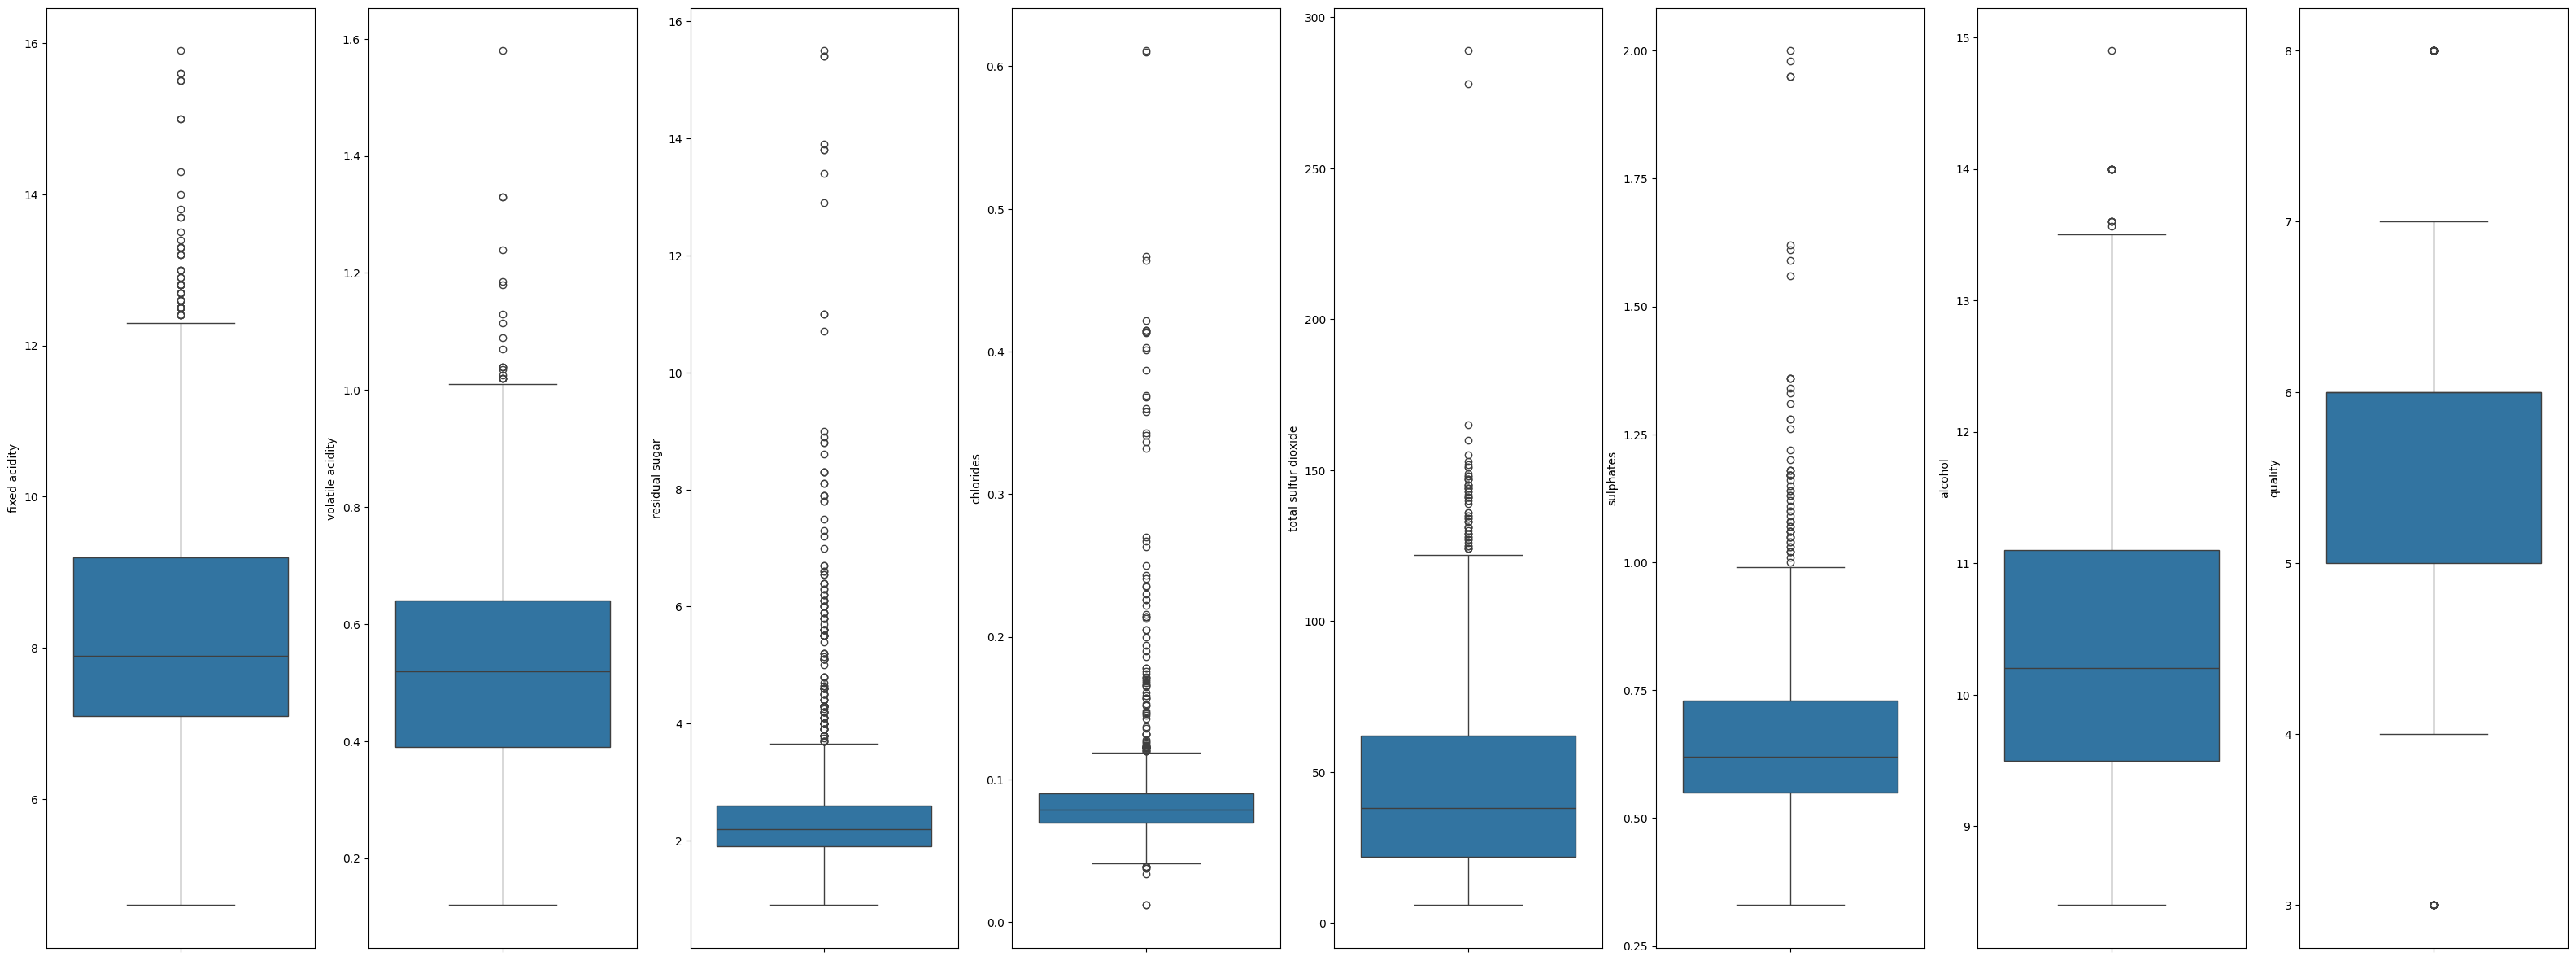

In [71]:
fig, axes = plt.subplots(1, data.shape[1], figsize=(40, 15))

for i, j in enumerate(data.columns.to_list()):
    sns.boxplot(data[j], ax=axes[i])

plt.show()

In [72]:
def outliers(data_col, left=1.5, right=1.5):
    mu = data_col.mean()
    sigma = data_col.std()
    
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    
    cleaned = data[(data_col > lower_bound) & (data_col < upper_bound)]
    
    return cleaned

In [73]:
# Очистим от выбросов фит алкоголь, так как есть предположение,
# что химический состав вина обоснован техпроцессом и разлет в 
# этих данных сложно интерпретировать как выбросы, да и дофига инфы потеряем
data = outliers(data["alcohol"])

In [74]:
data.shape

(1451, 8)

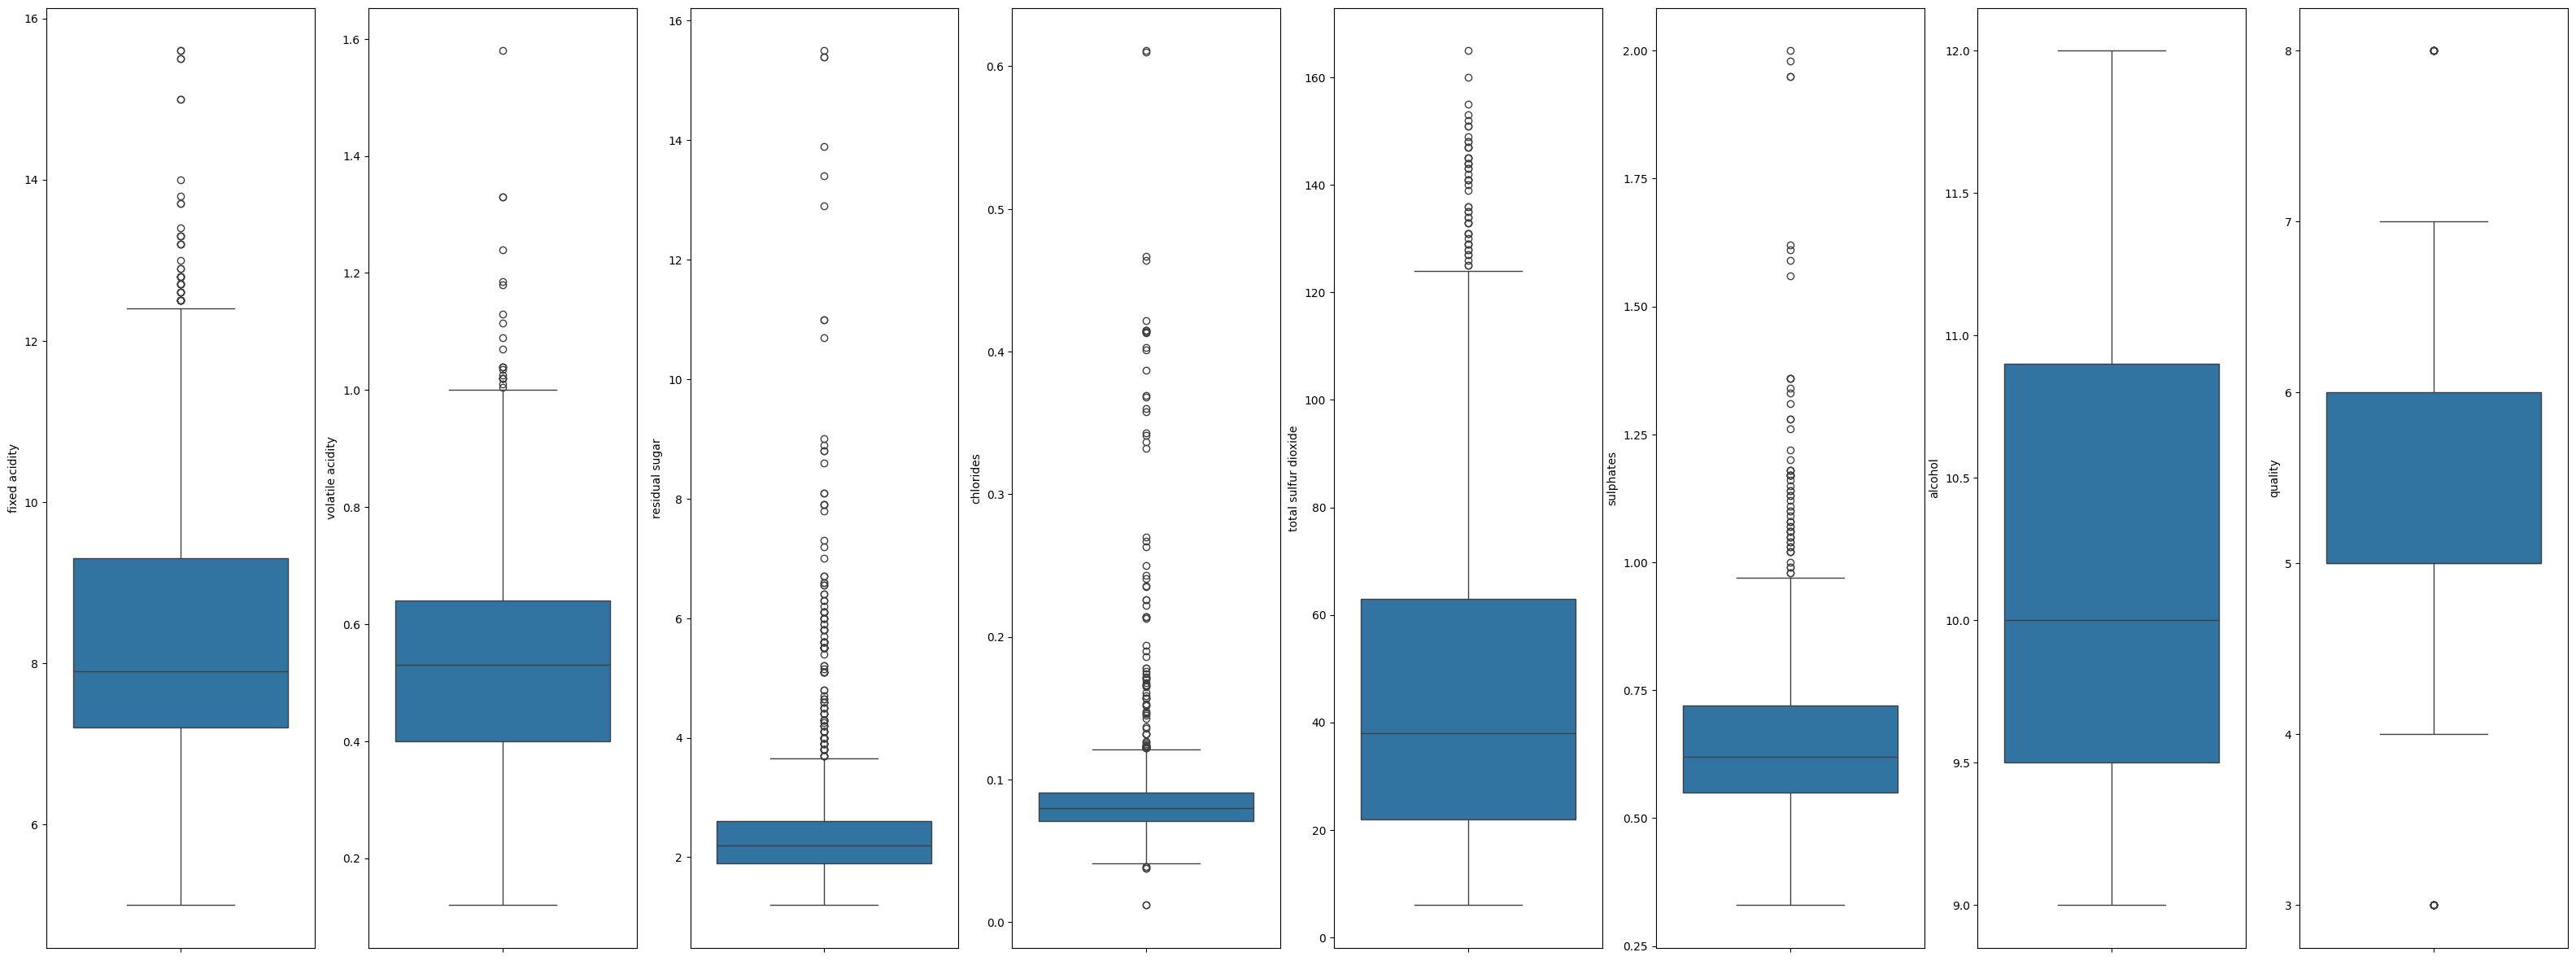

In [75]:
fig, axes = plt.subplots(1, data.shape[1], figsize=(40, 15))

for i, j in enumerate(data.columns.to_list()):
    sns.boxplot(data[j], ax=axes[i])

plt.show()

#### Пока хватит с обработкой.

---

#### Закодируем целевую переменную категориальной ('bad wine': quality < 6.5 и 'good wine': quality > 6.5) или в нашем случае бинарной классификации  (0: quality < 6.5 и 1: quality > 6.5)

In [76]:
# Кодируем признак
data["quality"] = data["quality"].apply(lambda x: 0 if x < 6.5 else 1)

# Посмотрим на распределение классов
data["quality"].value_counts(normalize=True)

quality
0    0.895934
1    0.104066
Name: proportion, dtype: float64

#### Классы не сбалансированы.

---
#### Разобьем на трейн тест

In [77]:
X = data.drop("quality", axis=1)
y = data["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [78]:
# Посмотрим на сбалансированность классов
y_train.value_counts(normalize=True)

quality
0    0.89569
1    0.10431
Name: proportion, dtype: float64

In [79]:
y_test.value_counts(normalize=True)

quality
0    0.896907
1    0.103093
Name: proportion, dtype: float64

#### Баланс классов в трейн и тесте соответсвует балансу в датафрейме.

---
#### Отмасштабируем признаки

In [80]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [81]:
display(X_train_scaled, X_test_scaled)

array([[-0.03237793,  0.01770314, -0.46225069, ..., -0.22288411,
        -0.26630157, -0.25127719],
       [ 2.56828392, -0.8159496 ,  0.01098088, ..., -0.84882667,
         0.90317857,  0.11945965],
       [-0.51622199, -0.76037275, -0.69886647, ...,  0.34046418,
        -0.43337017, -0.99275087],
       ...,
       [-0.81862453,  0.24001054,  1.8250352 , ...,  0.68473259,
         0.2349042 ,  0.98451228],
       [ 0.45146614, -0.20460426, -0.46225069, ..., -0.94271805,
         0.29059373,  0.36661754],
       [-0.75814403,  1.21260541, -0.54112262, ...,  1.1541895 ,
        -0.87888641, -0.86917193]])

array([[-0.33478047,  0.04549157,  0.01098088, ..., -0.37936975,
        -0.26630157,  1.72598596],
       [-0.5767025 ,  0.07327999, -0.54112262, ..., -0.41066688,
         0.12352514,  0.36661754],
       [-0.81862453, -0.26018111,  2.45601062, ...,  2.31218323,
         0.56904139,  0.36661754],
       ...,
       [-0.75814403, -0.5936422 , -0.54112262, ...,  0.12138429,
        -0.09923298,  0.2430386 ],
       [-0.63718301,  0.29558739,  3.71796146, ...,  2.31218323,
        -0.93457594, -0.99275087],
       [-0.51622199,  0.24001054, -0.38337876, ..., -0.0976956 ,
        -1.26871313, -1.11632982]])

---

#### Подбор оптимального сета параметров для модели.

In [83]:
# Подберем параметры по сетке
param_grid = {
    "C": np.linspace(0.1, 1.5, 10),
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto'],
}

random_cv = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
)

random_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([0.1       , 0.25555556, 0.41111111, 0.56666667, 0.72222222,
       0.87777778, 1.03333333, 1.18888889, 1.34444444, 1.5       ]),
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [84]:
# Посмотрим на оптимальные параметры
print(random_cv.best_params_)

{'C': 0.5666666666666667, 'gamma': 'scale', 'kernel': 'rbf'}


In [103]:
# Посмотрим на оценку accuracy на сетке
print(random_cv.best_score_)

0.8982758620689655


In [86]:
# Сделаем предсказание для теста
svc_model = SVC(**random_cv.best_params_)
svc_model.fit(X_train_scaled, y_train)

y_pred = svc_model.predict(X_test_scaled)

In [89]:
# Посмотрим на accuracy модели с лучшими параметрами на тесте
print(round(accuracy_score(y_test, y_pred), 2))

0.91

In [102]:
# Посмотрим на confusion matrix модели с лучшими параметрами на тесте
cf_score = confusion_matrix(y_test, y_pred)

pd.DataFrame(cf_score, index=["Класс_0", "Класс_1"], columns=["Соответсвует предсказанию", "Не соответсвует предсказанию"])

,Соответсвует предсказанию,Не соответсвует предсказанию
Класс_0,261,0
Класс_1,26,4


____
### Вывод:
#### Мы получили точность предсказания классов равными ~ 91 %
#### Матрица дала подсказку, что, вероятно, модель не справляется в некоторых моментах из-за несбалансированности классов.